In [1]:
# TESTING DIFFERENT THRESHOLDS FOR FILTERING ATAC
# conda remove --name SCENIC --all
# conda create --name SCENIC python=3.6.3 
# conda activate SCENIC
# python -m pip install pandas
# git clone https://github.com/aertslab/pycisTopic.git
# cd pycisTopic
# python -m pip install .
# python -m pip install --upgrade pip setuptools
# python -m pip install scanpy
# python -m pip install  pyranges
# python -m pip install requests --ignore-installed certifi
# python -m pip install ray
# python -m pip install tmtoolkit
# python -m pip install gensim
# python -m pip install loomxpy
# python -m pip install pyrle
# python -m pip install polars
# python -m pip  install typing-extensions --upgrade
# python -m pip install pyarrow
# python -m pip install loompy
# python -m pip install pyscenic
# python -m pip install pickle5
# python -m pip install ipykernel
#  python -m pip install pyBigWig
# install jupyter-lab
# mv pycisTopic/ pycisTopic_repo
#git clone https://github.com/aertslab/scenicplus
#cd scenicplus
#pip install .



import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import scanpy
import os
import requests
import pyranges as pr
import pycisTopic
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
from pycisTopic.iterative_peak_calling import *
import anndata
import pickle
import pyarrow 
import re


def CountFrequency(my_list):
 
    # Creating an empty dictionary
    freq = {}
    for items in my_list:
        freq[items] = my_list.count(items)
 
    for key, value in freq.items():
        print("% s : % d" % (key, value))
 

outDir="SCENIC_results_MARCH2024/"
tmpDir="/tmp/"
#ray.shutdown()

In [2]:
pwd

'/mnt/ceph/mbp/servers/bioinformatics-platform/home/lper0012/tasks/margo.montandon/Analysis/SCENIC_MARCH2024'

In [3]:

# use the correct ranges for your reference genome
# this comes from "~/data/tasks/margo.montandon/Analysis/basic_analysis.Rmd"

genomeref = pd.read_pickle(r"~/tasks/margo.montandon/Analysis/GenomeRef_pyAnnotation.obj")
genomeref

,Chromosome,Start,End,Name
0,1,0,43039672,1
1,2,0,39555667,2
2,3,0,60282382,3
3,4,0,76270779,4
4,5,0,61329656,5
...,...,...,...,...
262,KZ116053.1,0,10784,KZ116053.1
263,KZ116055.1,0,1335,KZ116055.1
264,KZ116064.1,0,82859,KZ116064.1
265,KZ116065.1,0,20619,KZ116065.1


In [4]:
# read the annaData. This comes from ~/data/tasks/margo.montandon/Analysis/basic_analysis.Rmd conversion step
# inside R when saving Seurat object
# library(scater)
# SaveH5Seurat(sobj.merged,"~/data/tasks/margo.montandon/Analysis/sobj.merged")
# Convert("~/data/tasks/margo.montandon/Analysis/sobj.merged.h5seurat", dest = "h5ad")

cell_data=scanpy.read_h5ad("../sobj.merged.h5ad")


In [5]:
cell_data.gene_names=cell_data.var
cluster='cluster_'
cell_df=cell_data.obs
barcodes_names=list(cell_df.index)
cell_df['barcodes_names']=barcodes_names
barcodes=[re.sub(".df_", "", x) for x in barcodes_names]
cell_df['barcodes']=barcodes
cell_df['cellnames']=cell_df['barcodes'] + '-' + cell_df['orig.ident']
cell_df.index = cell_df['cellnames']
#cell_df.index

cell_data.index=cell_df.index 

#anndata.AnnData.to_df(cell_data.obs)

#variable = 'VSN_cell_type', -->seurat_clusters
#sample_id_col = 'VSN_sample_id', --> orig.ident
#cell_df.head

In [6]:
type(cell_df)

pandas.core.frame.DataFrame

In [7]:
sample_id_col = 'orig.ident'
sample_ids = list(set(cell_df[sample_id_col]))
sample_ids 

['6dpf', '2dpf', '4dpf']

In [8]:

fragments_dict={'6dpf':"/mnt/ceph/mbp/servers/bioinformatics-platform/home/lper0012/tasks/margo.montandon//countmatrix//6dpf/atac_fragments.tsv.gz",
                '4dpf':"/mnt/ceph/mbp/servers/bioinformatics-platform/home/lper0012/tasks/margo.montandon//countmatrix//4dpf/atac_fragments.tsv.gz",
                '2dpf':"/mnt/ceph/mbp/servers/bioinformatics-platform/home/lper0012/tasks/margo.montandon//countmatrix//2dpf/atac_fragments.tsv.gz"}
fragments_dict

{'6dpf': '/mnt/ceph/mbp/servers/bioinformatics-platform/home/lper0012/tasks/margo.montandon//countmatrix//6dpf/atac_fragments.tsv.gz',
 '4dpf': '/mnt/ceph/mbp/servers/bioinformatics-platform/home/lper0012/tasks/margo.montandon//countmatrix//4dpf/atac_fragments.tsv.gz',
 '2dpf': '/mnt/ceph/mbp/servers/bioinformatics-platform/home/lper0012/tasks/margo.montandon//countmatrix//2dpf/atac_fragments.tsv.gz'}

In [9]:
cell_df.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC',
       'nFeature_ATAC', 'condition', 'nCount_SCT', 'nFeature_SCT',
       'SCT.weight', 'ATAC.weight', 'wsnn_res.0.1', 'wsnn_res.0.2',
       'wsnn_res.0.3', 'wsnn_res.0.4', 'wsnn_res.0.5', 'wsnn_res.0.6',
       'wsnn_res.0.7', 'wsnn_res.0.8', 'wsnn_res.0.9', 'wsnn_res.1',
       'wsnn_res.1.1', 'wsnn_res.1.2', 'wsnn_res.1.3', 'wsnn_res.1.4',
       'wsnn_res.1.5', 'wsnn_res.1.6', 'wsnn_res.1.7', 'wsnn_res.1.8',
       'wsnn_res.1.9', 'wsnn_res.2', 'seurat_clusters', 'barcodes_names',
       'barcodes', 'cellnames'],
      dtype='object')

In [10]:
cell_df

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_ATAC,nFeature_ATAC,condition,nCount_SCT,nFeature_SCT,SCT.weight,...,wsnn_res.1.5,wsnn_res.1.6,wsnn_res.1.7,wsnn_res.1.8,wsnn_res.1.9,wsnn_res.2,seurat_clusters,barcodes_names,barcodes,cellnames
cellnames,,,,,,,,,,,,,,,,,,,,,
AAACAGCCAACTAGGG-1-2dpf,2dpf,1781.0,796,2.919708,529.0,271,2dpf,1889.0,796,0.432149,...,1,1,1,1,1,1,1,2df_AAACAGCCAACTAGGG-1,AAACAGCCAACTAGGG-1,AAACAGCCAACTAGGG-1-2dpf
AAACAGCCATTATGGT-1-2dpf,2dpf,2521.0,976,3.292344,518.0,272,2dpf,2204.0,976,0.658799,...,0,0,0,0,0,0,0,2df_AAACAGCCATTATGGT-1,AAACAGCCATTATGGT-1,AAACAGCCATTATGGT-1-2dpf
AAACATGCATAATCGT-1-2dpf,2dpf,405.0,290,1.975309,313.0,162,2dpf,1434.0,350,0.511921,...,1,1,1,1,1,1,1,2df_AAACATGCATAATCGT-1,AAACATGCATAATCGT-1,AAACATGCATAATCGT-1-2dpf
AAACCAACAACCGCCA-1-2dpf,2dpf,538.0,434,2.230483,2621.0,1326,2dpf,1459.0,476,0.585348,...,12,12,12,12,12,12,2,2df_AAACCAACAACCGCCA-1,AAACCAACAACCGCCA-1,AAACCAACAACCGCCA-1-2dpf
AAACCAACAAGACTCC-1-2dpf,2dpf,1134.0,795,1.410935,4188.0,2120,2dpf,1594.0,801,0.586019,...,9,9,9,9,8,8,16,2df_AAACCAACAAGACTCC-1,AAACCAACAAGACTCC-1,AAACCAACAAGACTCC-1-2dpf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATAATCCG-1-6dpf,6dpf,1403.0,850,0.498931,6283.0,2960,6dpf,1667.0,856,0.548053,...,3,3,3,3,3,3,11,6df_TTTGTGGCATAATCCG-1,TTTGTGGCATAATCCG-1,TTTGTGGCATAATCCG-1-6dpf
TTTGTGGCATAGCTTG-1-6dpf,6dpf,868.0,552,1.612903,3720.0,1802,6dpf,1735.0,594,0.523116,...,5,5,5,5,4,4,12,6df_TTTGTGGCATAGCTTG-1,TTTGTGGCATAGCTTG-1,TTTGTGGCATAGCTTG-1-6dpf
TTTGTGTTCACCGGTA-1-6dpf,6dpf,3819.0,987,1.675831,4408.0,2112,6dpf,2383.0,957,0.526085,...,28,28,29,29,31,30,4,6df_TTTGTGTTCACCGGTA-1,TTTGTGTTCACCGGTA-1,TTTGTGTTCACCGGTA-1-6dpf


In [11]:

from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
#RAY_DEDUP_LOGS=0 
#os.environ["RAY_IGNORE_UNHANDLED_ERRORS"]="1"

myclusterslist=['wsnn_res.0.1', 
                'wsnn_res.0.2',
                'wsnn_res.0.3', 
                'wsnn_res.0.4', 
                'wsnn_res.0.5', 
                'wsnn_res.0.6',
                'wsnn_res.0.7', 
                'wsnn_res.0.8', 
                'wsnn_res.0.9', 
                'wsnn_res.1',
                'wsnn_res.1.1', 
                'wsnn_res.1.2', 
                'wsnn_res.1.3', 
                'wsnn_res.1.4',
                'wsnn_res.1.5', 
                'wsnn_res.1.6', 
                'wsnn_res.1.7', 
                'wsnn_res.1.8',
                'wsnn_res.1.9', 
                'wsnn_res.2', 
                'seurat_clusters' ]


In [12]:
myclusterslist

['wsnn_res.0.1',
 'wsnn_res.0.2',
 'wsnn_res.0.3',
 'wsnn_res.0.4',
 'wsnn_res.0.5',
 'wsnn_res.0.6',
 'wsnn_res.0.7',
 'wsnn_res.0.8',
 'wsnn_res.0.9',
 'wsnn_res.1',
 'wsnn_res.1.1',
 'wsnn_res.1.2',
 'wsnn_res.1.3',
 'wsnn_res.1.4',
 'wsnn_res.1.5',
 'wsnn_res.1.6',
 'wsnn_res.1.7',
 'wsnn_res.1.8',
 'wsnn_res.1.9',
 'wsnn_res.2',
 'seurat_clusters']

In [13]:
for items in myclusterslist:
    cluster='cluster_'
    cell_df[items]=cluster + cell_df[items].astype(str)
    
    
    


In [14]:
# this one wa to figure out which resolution to use
#for items in myclusterslist:
 #       cluster='cluster_'
  #      cell_df[items]=cluster + cell_df[items].astype(str)

   #     bw_paths, bed_paths = export_pseudobulk(input_data = cell_df,
    #             variable = items, # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
     #            sample_id_col = 'orig.ident',
      #           chromsizes = genomeref,
       #          bed_path = outDir + 'consensus_peak_calling/pseudobulk_bed_files' + items ,# specify where pseudobulk_bed_files should be stored
        #         bigwig_path = outDir + 'consensus_peak_calling/pseudobulk_bw_files' + items, # specify where pseudobulk_bw_files should be stored
         #        path_to_fragments = fragments_dict, # location of fragment fiels
          #       n_cpu = 10, # specify the number of cores to use, we use ray for multi processing
           #      normalize_bigwig = True,
            #     remove_duplicates = True,
             #    _temp_dir = tmpDir + 'ray_spill',
              #   split_pattern = '-',
               #  use_polars = True)



In [15]:
cell_df

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_ATAC,nFeature_ATAC,condition,nCount_SCT,nFeature_SCT,SCT.weight,...,wsnn_res.1.5,wsnn_res.1.6,wsnn_res.1.7,wsnn_res.1.8,wsnn_res.1.9,wsnn_res.2,seurat_clusters,barcodes_names,barcodes,cellnames
cellnames,,,,,,,,,,,,,,,,,,,,,
AAACAGCCAACTAGGG-1-2dpf,2dpf,1781.0,796,2.919708,529.0,271,2dpf,1889.0,796,0.432149,...,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,2df_AAACAGCCAACTAGGG-1,AAACAGCCAACTAGGG-1,AAACAGCCAACTAGGG-1-2dpf
AAACAGCCATTATGGT-1-2dpf,2dpf,2521.0,976,3.292344,518.0,272,2dpf,2204.0,976,0.658799,...,cluster_0,cluster_0,cluster_0,cluster_0,cluster_0,cluster_0,cluster_0,2df_AAACAGCCATTATGGT-1,AAACAGCCATTATGGT-1,AAACAGCCATTATGGT-1-2dpf
AAACATGCATAATCGT-1-2dpf,2dpf,405.0,290,1.975309,313.0,162,2dpf,1434.0,350,0.511921,...,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,2df_AAACATGCATAATCGT-1,AAACATGCATAATCGT-1,AAACATGCATAATCGT-1-2dpf
AAACCAACAACCGCCA-1-2dpf,2dpf,538.0,434,2.230483,2621.0,1326,2dpf,1459.0,476,0.585348,...,cluster_12,cluster_12,cluster_12,cluster_12,cluster_12,cluster_12,cluster_2,2df_AAACCAACAACCGCCA-1,AAACCAACAACCGCCA-1,AAACCAACAACCGCCA-1-2dpf
AAACCAACAAGACTCC-1-2dpf,2dpf,1134.0,795,1.410935,4188.0,2120,2dpf,1594.0,801,0.586019,...,cluster_9,cluster_9,cluster_9,cluster_9,cluster_8,cluster_8,cluster_16,2df_AAACCAACAAGACTCC-1,AAACCAACAAGACTCC-1,AAACCAACAAGACTCC-1-2dpf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATAATCCG-1-6dpf,6dpf,1403.0,850,0.498931,6283.0,2960,6dpf,1667.0,856,0.548053,...,cluster_3,cluster_3,cluster_3,cluster_3,cluster_3,cluster_3,cluster_11,6df_TTTGTGGCATAATCCG-1,TTTGTGGCATAATCCG-1,TTTGTGGCATAATCCG-1-6dpf
TTTGTGGCATAGCTTG-1-6dpf,6dpf,868.0,552,1.612903,3720.0,1802,6dpf,1735.0,594,0.523116,...,cluster_5,cluster_5,cluster_5,cluster_5,cluster_4,cluster_4,cluster_12,6df_TTTGTGGCATAGCTTG-1,TTTGTGGCATAGCTTG-1,TTTGTGGCATAGCTTG-1-6dpf
TTTGTGTTCACCGGTA-1-6dpf,6dpf,3819.0,987,1.675831,4408.0,2112,6dpf,2383.0,957,0.526085,...,cluster_28,cluster_28,cluster_29,cluster_29,cluster_31,cluster_30,cluster_4,6df_TTTGTGTTCACCGGTA-1,TTTGTGTTCACCGGTA-1,TTTGTGTTCACCGGTA-1-6dpf


In [16]:
#resolution picked because heaviest file
resolution="wsnn_res.0.1"        
cell_df['clusters']=cluster + cell_df[resolution].astype(str)


bw_paths, bed_paths = export_pseudobulk(input_data = cell_df,
                 variable = resolution, # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'orig.ident',
                 chromsizes = genomeref,
                 bed_path = outDir + 'consensus_peak_calling/pseudobulk_bed_files' + resolution,# specify where pseudobulk_bed_files should be stored
                 bigwig_path = outDir + 'consensus_peak_calling/pseudobulk_bw_files' + resolution, # specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict, # location of fragment fiels
                 n_cpu = 10, # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = tmpDir + 'ray_spill',
                 split_pattern = '-',
                 use_polars = True)

2024-04-03 21:48:00,461 cisTopic     INFO     Reading fragments from /mnt/ceph/mbp/servers/bioinformatics-platform/home/lper0012/tasks/margo.montandon//countmatrix//6dpf/atac_fragments.tsv.gz
2024-04-03 21:50:22,454 cisTopic     INFO     Reading fragments from /mnt/ceph/mbp/servers/bioinformatics-platform/home/lper0012/tasks/margo.montandon//countmatrix//4dpf/atac_fragments.tsv.gz
2024-04-03 21:52:16,465 cisTopic     INFO     Reading fragments from /mnt/ceph/mbp/servers/bioinformatics-platform/home/lper0012/tasks/margo.montandon//countmatrix//2dpf/atac_fragments.tsv.gz
2024-04-03 21:53:39,557 root         INFO     Unable to poll TPU GCE metadata: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/attributes/accelerator-type (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f385cb5e850>: Failed to establish a new connection: [Errno -2] Name or service not known'))


2024-04-03 21:53:40,889	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(export_pseudobulk_ray pid=532664) 2024-04-03 21:53:46,438 cisTopic     INFO     Creating pseudobulk for cluster_0


(raylet) Spilled 3730 MiB, 5 objects, write throughput 352 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(export_pseudobulk_ray pid=532665) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=532665)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])
(raylet) Spilled 5595 MiB, 8 objects, write throughput 368 MiB/s.
(export_pseudobulk_ray pid=532664) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-loggin

(export_pseudobulk_ray pid=532657) 2024-04-03 21:54:35,609 cisTopic     INFO     cluster_11 done!
(export_pseudobulk_ray pid=532657) 2024-04-03 21:53:49,412 cisTopic     INFO     Creating pseudobulk for cluster_11 [repeated 3x across cluster]


(export_pseudobulk_ray pid=532657) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=532657)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=532656) 2024-04-03 21:54:38,934 cisTopic     INFO     cluster_10 done!
(export_pseudobulk_ray pid=532656) 2024-04-03 21:54:51,444 cisTopic     INFO     Creating pseudobulk for cluster_3 [repeated 2x across cluster]


(export_pseudobulk_ray pid=532656) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=532656)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=532657) 2024-04-03 21:55:17,869 cisTopic     INFO     cluster_2 done!
(export_pseudobulk_ray pid=532657) 2024-04-03 21:55:18,130 cisTopic     INFO     Creating pseudobulk for cluster_4


(export_pseudobulk_ray pid=532657) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=532657)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])
(export_pseudobulk_ray pid=532656) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=532656)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=532656) 2024-04-03 21:55:47,212 cisTopic     INFO     cluster_5 done! [repeated 2x across cluster]
(export_pseudobulk_ray pid=532656) 2024-04-03 21:55:21,919 cisTopic     INFO     Creating pseudobulk for cluster_5
(export_pseudobulk_ray pid=532656) 2024-04-03 21:55:47,481 cisTopic     INFO     Creating pseudobulk for cluster_6


(export_pseudobulk_ray pid=532656) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=532656)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=532665) 2024-04-03 21:56:07,962 cisTopic     INFO     cluster_1 done!
(export_pseudobulk_ray pid=532665) 2024-04-03 21:56:08,661 cisTopic     INFO     Creating pseudobulk for cluster_7


(export_pseudobulk_ray pid=532665) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=532665)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=532656) 2024-04-03 21:57:42,205 cisTopic     INFO     cluster_6 done!
(export_pseudobulk_ray pid=532656) 2024-04-03 21:57:42,369 cisTopic     INFO     Creating pseudobulk for cluster_8


(export_pseudobulk_ray pid=532656) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=532656)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=532657) 2024-04-03 21:57:47,356 cisTopic     INFO     cluster_4 done! [repeated 2x across cluster]
(export_pseudobulk_ray pid=532657) 2024-04-03 21:58:03,648 cisTopic     INFO     Creating pseudobulk for cluster_9


(export_pseudobulk_ray pid=532657) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=532657)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=532656) 2024-04-03 21:58:41,090 cisTopic     INFO     cluster_8 done!
(export_pseudobulk_ray pid=532657) 2024-04-03 21:58:59,125 cisTopic     INFO     cluster_9 done!


In [17]:
bw_paths

{'cluster_0': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bw_fileswsnn_res.0.1/cluster_0.bw',
 'cluster_1': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bw_fileswsnn_res.0.1/cluster_1.bw',
 'cluster_10': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bw_fileswsnn_res.0.1/cluster_10.bw',
 'cluster_11': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bw_fileswsnn_res.0.1/cluster_11.bw',
 'cluster_2': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bw_fileswsnn_res.0.1/cluster_2.bw',
 'cluster_3': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bw_fileswsnn_res.0.1/cluster_3.bw',
 'cluster_4': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bw_fileswsnn_res.0.1/cluster_4.bw',
 'cluster_5': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bw_fileswsnn_res.0.1/cluster_5.bw',
 'cluster_6': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bw_fileswsnn_res.0.1/cluster_6.bw',
 'clus

In [18]:
resolution="wsnn_res.0.1"

with open(outDir + 'consensus_peak_calling/pseudobulk_bed_files' + resolution +'/bed_paths.pkl' , 'wb') as f:
  pickle.dump(bed_paths, f)

bed_paths

{'cluster_0': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_0.bed.gz',
 'cluster_1': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_1.bed.gz',
 'cluster_10': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_10.bed.gz',
 'cluster_11': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_11.bed.gz',
 'cluster_2': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_2.bed.gz',
 'cluster_3': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_3.bed.gz',
 'cluster_4': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_4.bed.gz',
 'cluster_5': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_5.bed.gz',
 'cluster_6': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_be

In [19]:
  
with open(outDir + 'consensus_peak_calling/pseudobulk_bed_files' + resolution + '/bw_paths.pkl' , 'wb') as f:
  pickle.dump(bw_paths, f)

In [20]:
  
infile = open(outDir + 'consensus_peak_calling/pseudobulk_bed_files' + resolution + '/bed_paths.pkl' , 'rb')
bed_paths = pickle.load(infile)
infile.close()

bed_paths

{'cluster_0': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_0.bed.gz',
 'cluster_1': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_1.bed.gz',
 'cluster_10': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_10.bed.gz',
 'cluster_11': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_11.bed.gz',
 'cluster_2': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_2.bed.gz',
 'cluster_3': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_3.bed.gz',
 'cluster_4': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_4.bed.gz',
 'cluster_5': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_5.bed.gz',
 'cluster_6': 'SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_be

In [21]:

macs_path='macs2'
outdir = outDir + 'consensus_peak_calling/MACS/' 


In [22]:

# Run peak calling
from pycisTopic.pseudobulk_peak_calling import peak_calling

narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 outdir,
                                 genome_size='hs',
                                 n_cpu=6,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = tmpDir + 'ray_spill'
                                 )


2024-04-03 22:00:00,213 root         INFO     Unable to poll TPU GCE metadata: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/attributes/accelerator-type (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f309eaf8040>: Failed to establish a new connection: [Errno -2] Name or service not known'))


2024-04-03 22:00:00,415	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(macs_call_peak_ray pid=534556) 2024-04-03 22:00:06,235 cisTopic     INFO     Calling peaks for cluster_2 with macs2 callpeak --treatment SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_2.bed.gz --name cluster_2  --outdir SCENIC_results_MARCH2024/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=534558) 2024-04-03 22:00:31,024 cisTopic     INFO     cluster_11 done!
(macs_call_peak_ray pid=534558) 2024-04-03 22:00:06,235 cisTopic     INFO     Calling peaks for cluster_11 with macs2 callpeak --treatment SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_11.bed.gz --name cluster_11  --outdir SCENIC_results_MARCH2024/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda [repeated 5x across cluster]


(macs_call_peak_ray pid=534559) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:710: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
(macs_call_peak_ray pid=534559)   narrow_peak = pd.read_csv(


(macs_call_peak_ray pid=534559) 2024-04-03 22:00:39,611 cisTopic     INFO     cluster_10 done! [repeated 2x across cluster]
(macs_call_peak_ray pid=534554) 2024-04-03 22:00:33,082 cisTopic     INFO     Calling peaks for cluster_5 with macs2 callpeak --treatment SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_5.bed.gz --name cluster_5  --outdir SCENIC_results_MARCH2024/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda [repeated 2x across cluster]


(macs_call_peak_ray pid=534556) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:710: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
(macs_call_peak_ray pid=534556)   narrow_peak = pd.read_csv(


(macs_call_peak_ray pid=534556) 2024-04-03 22:00:48,491 cisTopic     INFO     cluster_2 done! [repeated 2x across cluster]
(macs_call_peak_ray pid=534554) 2024-04-03 22:00:40,270 cisTopic     INFO     Calling peaks for cluster_7 with macs2 callpeak --treatment SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_7.bed.gz --name cluster_7  --outdir SCENIC_results_MARCH2024/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda [repeated 2x across cluster]


(macs_call_peak_ray pid=534557) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:710: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
(macs_call_peak_ray pid=534557)   narrow_peak = pd.read_csv(


(macs_call_peak_ray pid=534557) 2024-04-03 22:01:23,724 cisTopic     INFO     cluster_1 done!
(macs_call_peak_ray pid=534556) 2024-04-03 22:00:48,543 cisTopic     INFO     Calling peaks for cluster_8 with macs2 callpeak --treatment SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_8.bed.gz --name cluster_8  --outdir SCENIC_results_MARCH2024/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=534557) 2024-04-03 22:01:23,814 cisTopic     INFO     Calling peaks for cluster_9 with macs2 callpeak --treatment SCENIC_results_MARCH2024/consensus_peak_calling/pseudobulk_bed_fileswsnn_res.0.1/cluster_9.bed.gz --name cluster_9  --outdir SCENIC_results_MARCH2024/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda


(macs_call_peak_ray pid=534556) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:710: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
(macs_call_peak_ray pid=534556)   narrow_peak = pd.read_csv(


(macs_call_peak_ray pid=534556) 2024-04-03 22:01:40,993 cisTopic     INFO     cluster_8 done!


(macs_call_peak_ray pid=534558) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:710: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
(macs_call_peak_ray pid=534558)   narrow_peak = pd.read_csv(


(macs_call_peak_ray pid=534558) 2024-04-03 22:02:04,066 cisTopic     INFO     cluster_4 done!


(macs_call_peak_ray pid=534557) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:710: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
(macs_call_peak_ray pid=534557)   narrow_peak = pd.read_csv(


(macs_call_peak_ray pid=534557) 2024-04-03 22:02:08,915 cisTopic     INFO     cluster_9 done!


(macs_call_peak_ray pid=534559) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:710: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
(macs_call_peak_ray pid=534559)   narrow_peak = pd.read_csv(
(macs_call_peak_ray pid=534555) /home/lper0012/.local/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py:710: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False. [repeated 2x across cluster]
(macs_call_peak_ray pid=534555)   narrow_peak = pd.read_csv( [repeated 2x across cluster]


(macs_call_peak_ray pid=534555) 2024-04-03 22:02:35,430 cisTopic     INFO     cluster_0 done! [repeated 3x across cluster]


In [23]:

with open(outDir + 'consensus_peak_calling/MACS/narrow_peaks_dict.pkl', 'wb') as f:
  pickle.dump(narrow_peaks_dict, f)
  
narrow_peaks_dict

{'cluster_0': +--------------+-----------+-----------+-------------------------+-------+
 | Chromosome   | Start     | End       | Name                    | +6    |
 | (category)   | (int64)   | (int64)   | (object)                | ...   |
 |--------------+-----------+-----------+-------------------------+-------|
 | 1            | 4168      | 4320      | cluster_0_peak_1        | ...   |
 | 1            | 5223      | 6661      | cluster_0_peak_2a       | ...   |
 | 1            | 5223      | 6661      | cluster_0_peak_2b       | ...   |
 | 1            | 8033      | 8204      | cluster_0_peak_3        | ...   |
 | ...          | ...       | ...       | ...                     | ...   |
 | MT           | 5         | 16596     | cluster_0_peak_192973cv | ...   |
 | MT           | 5         | 16596     | cluster_0_peak_192973cw | ...   |
 | MT           | 5         | 16596     | cluster_0_peak_192973cx | ...   |
 | MT           | 5         | 16596     | cluster_0_peak_192973cy | ...   |

In [24]:
peak_half_width=250
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=genomeref)
#consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)
consensus_peaks.to_bed(path= outDir + 'consensus_peak_calling/consensus_regions.bed', keep=True, compression='infer', chain=False)


2024-04-03 22:02:54,146 cisTopic     INFO     Extending and merging peaks per class
2024-04-03 22:04:19,103 cisTopic     INFO     Normalizing peak scores
2024-04-03 22:04:19,573 cisTopic     INFO     Merging peaks
2024-04-03 22:05:39,288 cisTopic     INFO     Done!


In [25]:

import pybiomart as pbm
# For mouse (mm39)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For mouse (mm10)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human (hg38)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg19)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly (dm6)
# dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
#https://asia.ensembl.org/
#http://www.ensembl.org
#dataset = pbm.Dataset(name='drerio_gene_ensembl',  host='http://www.ensembl.org')
#dataset

dataset = pbm.Dataset(name='drerio_gene_ensembl',  host='http://www.ensembl.org')
dataset


<biomart.Dataset name='drerio_gene_ensembl', display_name=''>

In [26]:
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
#filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot

,Chromosome/scaffold name,Transcription start site (TSS),Strand,Gene name,Transcript type
0,24,20927202,1,fam162a,protein_coding
1,24,20927135,1,fam162a,protein_coding
2,17,50472985,-1,si:ch211-235i11.3,protein_coding
3,17,50472864,-1,si:ch211-235i11.3,protein_coding
4,1,49266886,1,caly,protein_coding
...,...,...,...,...,...
61625,11,43070883,1,CABZ01080006.1,lincRNA
61626,11,43643158,1,CABZ01073015.1,lincRNA
61627,11,44120354,-1,FO704721.3,lincRNA
61628,11,44116448,-1,FO704721.3,lincRNA


In [27]:
#annot = annot[~filter]
#annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
annot['Chromosome']

0        24
1        24
2        17
3        17
4         1
         ..
60816    MT
60817    MT
60821    MT
60822    MT
60824    MT
Name: Chromosome, Length: 47388, dtype: object

In [28]:
from pycisTopic.qc import *


path_to_regions = {'2dpf':outDir + 'consensus_peak_calling/consensus_regions.bed',
                   '4dpf':outDir + 'consensus_peak_calling/consensus_regions.bed',
                   '6dpf':outDir + 'consensus_peak_calling/consensus_regions.bed'}

#path_to_regions = {'4dpf':outDir + 'consensus_peak_calling/consensus_regions.bed'}

metadata_bc, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = tmpDir + 'ray_spill',
                use_polars = True)

2024-04-03 22:05:48,776 cisTopic     INFO     Reading 6dpf
2024-04-03 22:07:54,322 cisTopic     INFO     Computing barcode rank plot for 6dpf
2024-04-03 22:07:54,324 cisTopic     INFO     Counting fragments
2024-04-03 22:08:02,349 cisTopic     INFO     Marking barcodes with more than 100
2024-04-03 22:08:02,386 cisTopic     INFO     Returning plot data
2024-04-03 22:08:02,396 cisTopic     INFO     Returning valid barcodes
2024-04-03 22:08:12,883 cisTopic     INFO     Computing duplicate rate plot for 6dpf
2024-04-03 22:08:25,722 cisTopic     INFO     Return plot data
2024-04-03 22:08:26,026 cisTopic     INFO     Computing insert size distribution for 6dpf
2024-04-03 22:08:26,027 cisTopic     INFO     Counting fragments
2024-04-03 22:08:32,398 cisTopic     INFO     Returning plot data
2024-04-03 22:09:42,388 cisTopic     INFO     Computing TSS profile for 6dpf
2024-04-03 22:09:53,943 cisTopic     INFO     Formatting annnotation
2024-04-03 22:09:54,028 cisTopic     INFO     Creating cove

In [30]:


#os.makedirs(outDir+'quality_control')


import pickle
with open(outDir + 'quality_control/metadata_bc.pkl', 'wb') as f:
  pickle.dump(metadata_bc, f)

import pickle
with open(outDir + 'quality_control/profile_data_dict.pkl', 'wb') as f:
  pickle.dump(profile_data_dict, f)

In [31]:

import pickle
infile = open(outDir + 'quality_control/profile_data_dict.pkl', 'rb')
profile_data_dict = pickle.load(infile)
infile.close()

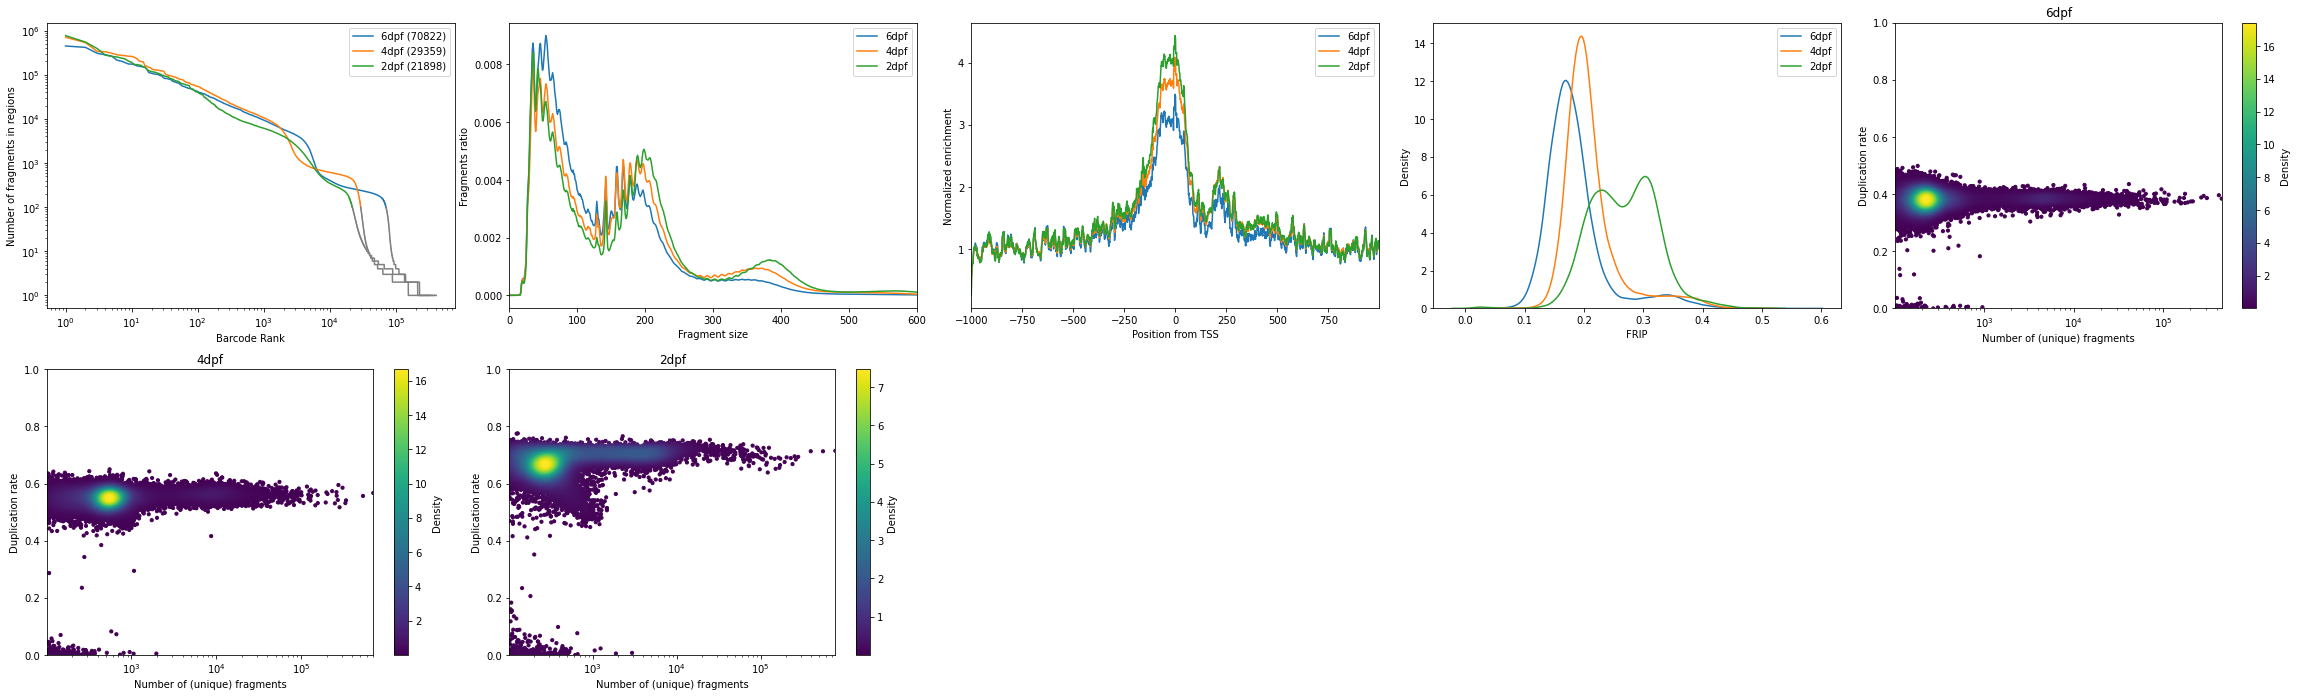

In [32]:
from pycisTopic.qc import *
plot_sample_metrics(profile_data_dict,
           insert_size_distribution_xlim=[0,600],
           ncol=5,
           plot=True,
           save= outDir + 'quality_control/sample_metrics.pdf')

# fragment size -> "cuts" around nucleosome that are accesible, marks  100 and 200 and 300. Indicateing that I have good signal of my peaks   

# Normalized enrichment: the normalization shows if I have signal of enrichment on the TSS accesibility

# FRIP: ~20% of my reads are around peaks~

In [33]:
## start here
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()



In [34]:
metadata_bc.items()

dict_items([('6dpf',                     Log_total_nr_frag  Log_unique_nr_frag  Total_nr_frag  \
CCTAAGCCAAACTAAG-1           3.804412            3.593175           6374   
ACGTCAAGTGCGCATG-1           4.307795            4.102228          20314   
AAGTTTGTCGTTATCT-1           2.658011            2.450249            455   
TTGACATCAACACCTA-1           4.954614            4.736763          90077   
GTACTTCGTCATGCCC-1           2.647383            2.419956            444   
...                               ...                 ...            ...   
GCGGATACAGGTTTGC-1           2.176091            2.017033            150   
CCTCAATGTTTAACGG-1           2.357935            2.139879            228   
TATGGTCAGCCAGTAT-1           2.217484            2.021189            165   
GCCTGCTGTGTTCCCA-1           2.201397            2.017033            159   
CCGCCAACATAGGCGA-1           2.399674            2.181844            251   

                    Unique_nr_frag  Dupl_nr_frag  Dupl_rate  \
CCT

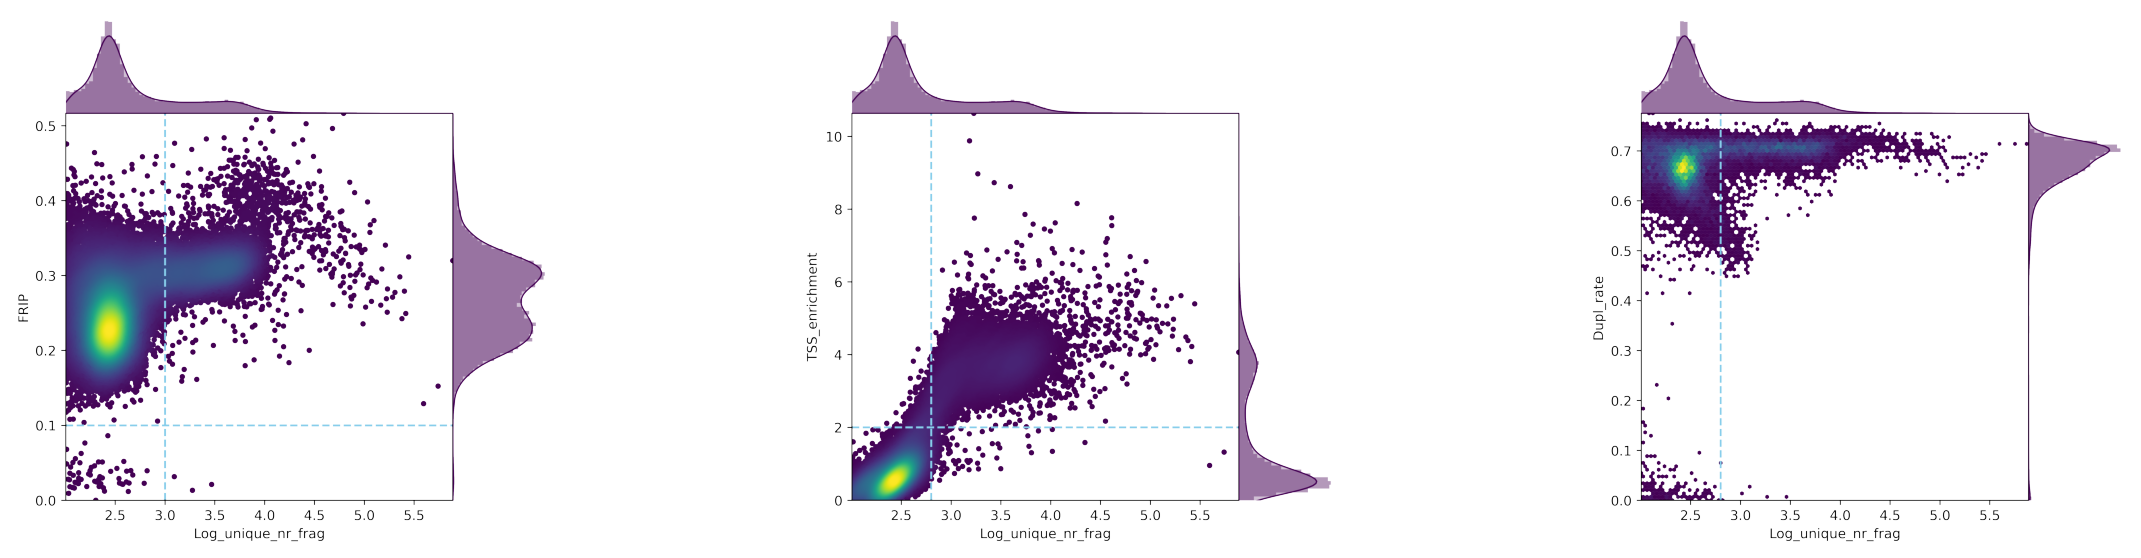

3

In [35]:
# change the min_x and min_y to include more cells
min_x=2.5
min_y=0.2

FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['2dpf'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=3,
                                       max_x=None,
                                       min_y=0.1,
                                       max_y=None,
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False,
                                       save= outDir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG_2dpf.pdf')
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['2dpf'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=2.8,
                                      max_x=None,
                                      min_y=2,
                                      max_y=None,
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False,
                                      save= outDir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG_2dpf.pdf')
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['2dpf'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=2.8,
                                      max_x=None,
                                      min_y=None,
                                      max_y=None,
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(40,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()


bc_passing_filters = {'2dpf':[],'4dpf':[],'6dpf':[]}
bc_passing_filters['2dpf']= list(set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter))
len(bc_passing_filters)

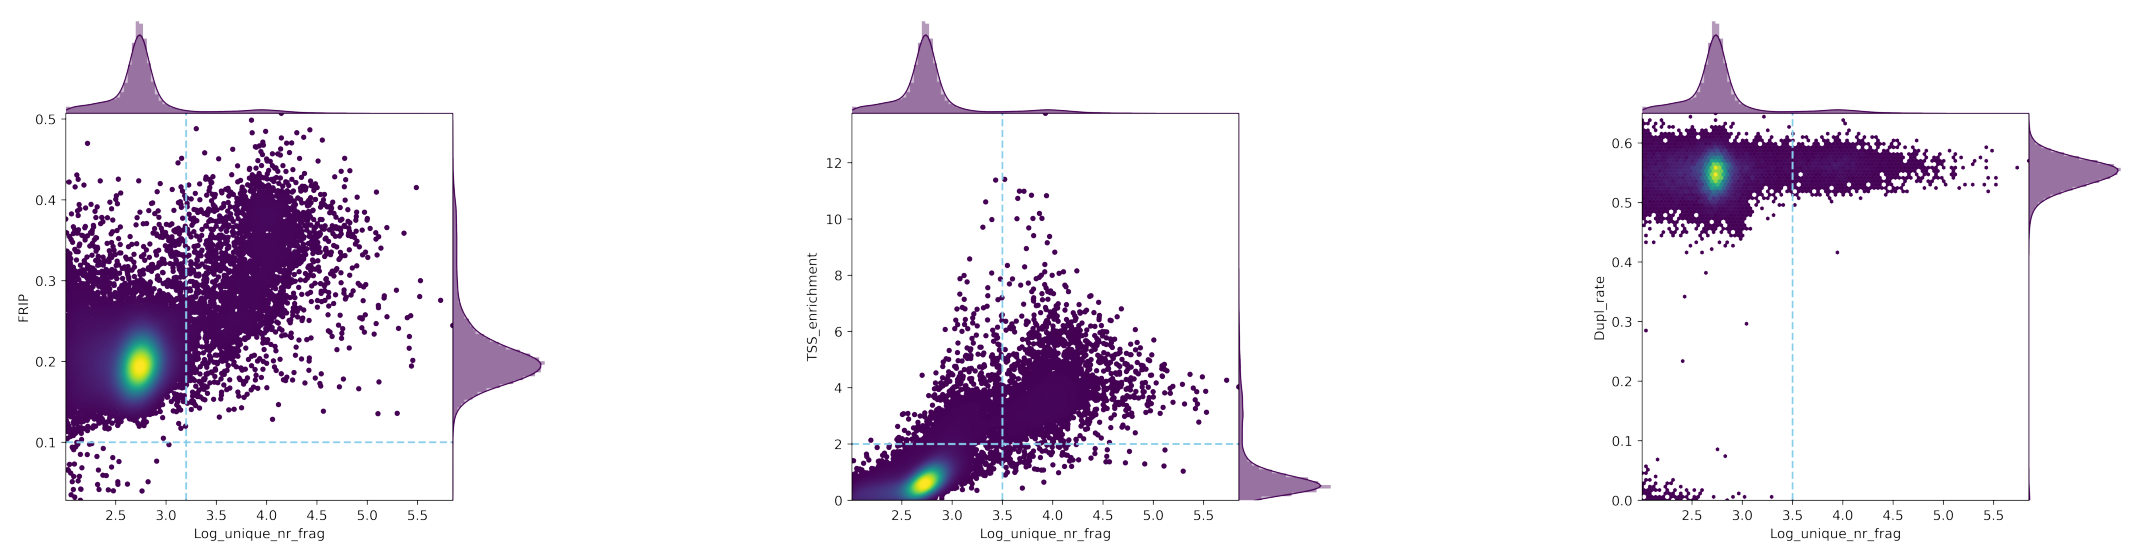

3

In [36]:


FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['4dpf'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=3.2,
                                       max_x=None,
                                       min_y=0.1,
                                       max_y=None,
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False,
                                       save= outDir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG_4dpf.pdf')
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['4dpf'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=2,
                                      max_y=None,
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False,
                                      save= outDir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG_4dpf.pdf')
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['4dpf'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=None,
                                      max_y=None,
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(40,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

bc_passing_filters['4dpf']= list(set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter))
len(bc_passing_filters)


In [37]:

#bc_passing_filters_4dpf = list(set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter))
#bc_passing_filters = (bc_passing_filters + bc_passing_filters_4dpf)
#len(bc_passing_filters_4dpf)




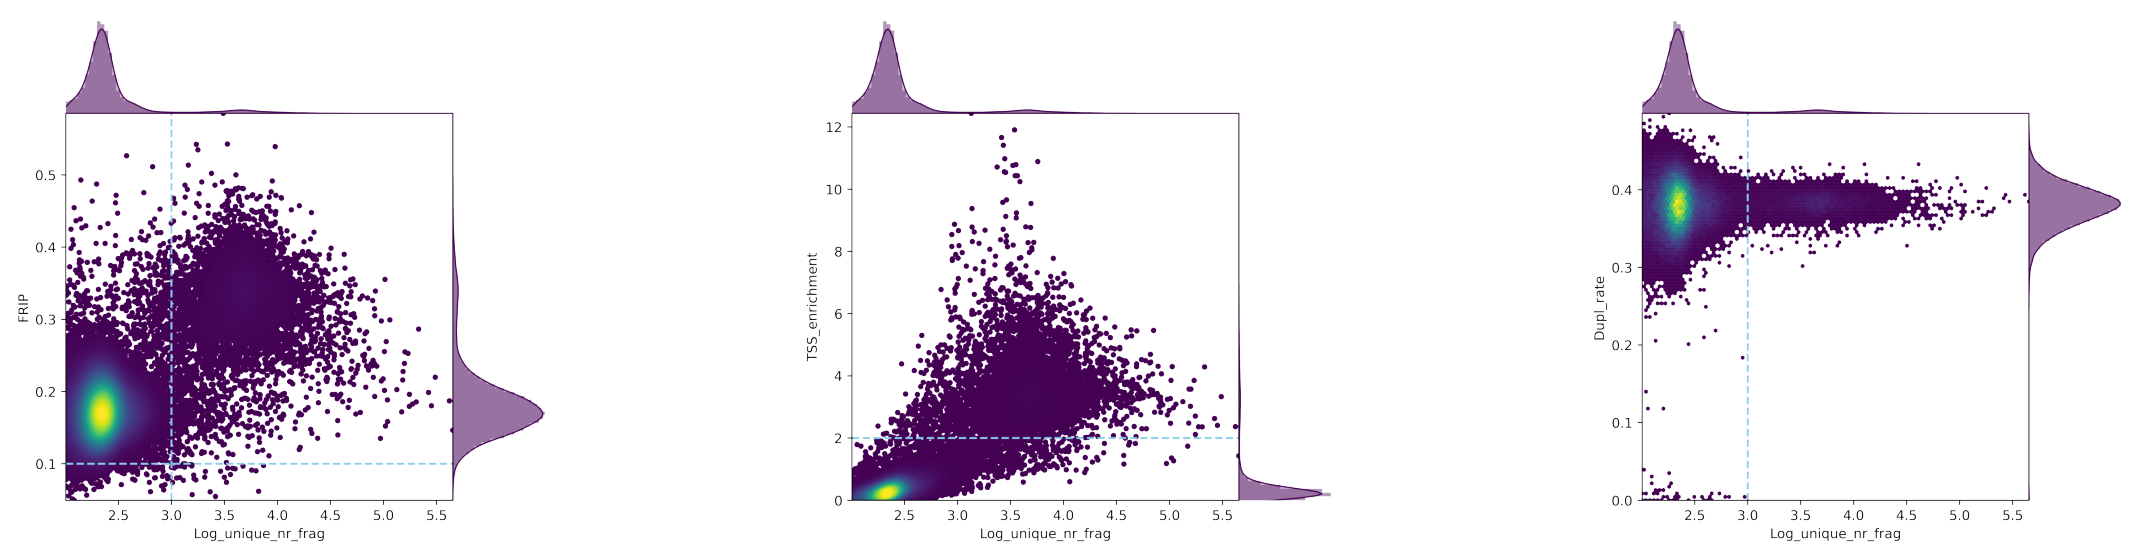

3

In [38]:


FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['6dpf'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=3,
                                       max_x=None,
                                       min_y=0.1,
                                       max_y=None,
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False,
                                       save= outDir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG_6dpf.pdf')
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['6dpf'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=2,
                                      max_x=None,
                                      min_y=2,
                                      max_y=None,
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False,
                                      save= outDir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG_6dpf.pdf')
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['6dpf'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=3,
                                      max_x=None,
                                      min_y=None,
                                      max_y=None,
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(40,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()


#bc_passing_filters_6dpf = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
#bc_passing_filters = (bc_passing_filters + bc_passing_filters_6dpf)
#len(bc_passing_filters_6dpf)


bc_passing_filters['6dpf']= list(set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter))
len(bc_passing_filters)

In [39]:
len(bc_passing_filters['2dpf'])

5095

In [40]:
len(bc_passing_filters['4dpf'])

2297

In [41]:
len(bc_passing_filters['6dpf'])

5106

In [42]:
# Get metadata from high-quality loom file
scRNA_bc=[re.sub("-.dpf", "", x) for x in cell_df.index.tolist()]
#scRNA_bc
#len(bc_passing_filters)
#len(list(set(bc_passing_filters) & set(scRNA_bc)))
#bc_passing_filters[['2dpf','4dpf']]


In [43]:
outDir


'SCENIC_results_MARCH2024/'

In [44]:
with open(outDir + 'quality_control/bc_passing_filters.pkl', 'wb') as f:
  pickle.dump(bc_passing_filters, f)